In [1]:
import requests
import json
import os
from datetime import datetime


## Importing from pyspark after setting JAVA_HOME
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home'
os.environ['PATH'] = os.path.join(os.environ['JAVA_HOME'], 'bin') + ':' + os.environ.get('PATH', '')
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, upper, trim, current_timestamp, monotonically_increasing_id



In [2]:
spark = SparkSession.builder \
    .appName("AutomobileAPIIngestion") \
    .master("local[*]") \
    .getOrCreate()

spark


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/18 18:24:50 WARN Utils: Your hostname, Sandeeps-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.201 instead (on interface en0)
25/12/18 18:24:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/18 18:24:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
api_url = "https://vpic.nhtsa.dot.gov/api/vehicles/getallmakes?format=json"

In [4]:
response = requests.get(api_url)
data_json = response.json()

Bronze Layer for Getting all the Raw Data

In [5]:
from datetime import datetime

BRONZE_PATH = "data/bronze"
os.makedirs(BRONZE_PATH, exist_ok=True)

MAKES = ["honda", "toyota", "ford", "nissan", "bmw"]

def fetch_models(make):
    url = f"https://vpic.nhtsa.dot.gov/api/vehicles/getmodelsformake/{make}?format=json"
    print("Fetching:", url)
    response = requests.get(url)
    return response.json().get("Results", [])

# Fetch & saving the  raw JSON 
all_models = []
for make in MAKES:
    rows = fetch_models(make)
    for r in rows:
        r["QueriedMake"] = make
    all_models.extend(rows)

timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
bronze_file = f"{BRONZE_PATH}/automobiles_{timestamp}.json"

with open(bronze_file, "w") as f:
    json.dump(all_models, f)

print("Bronze snapshot saved:", bronze_file)


Fetching: https://vpic.nhtsa.dot.gov/api/vehicles/getmodelsformake/honda?format=json
Fetching: https://vpic.nhtsa.dot.gov/api/vehicles/getmodelsformake/toyota?format=json
Fetching: https://vpic.nhtsa.dot.gov/api/vehicles/getmodelsformake/ford?format=json
Fetching: https://vpic.nhtsa.dot.gov/api/vehicles/getmodelsformake/nissan?format=json
Fetching: https://vpic.nhtsa.dot.gov/api/vehicles/getmodelsformake/bmw?format=json
Bronze snapshot saved: data/bronze/automobiles_20251219_002457.json


/var/folders/w7/jmxdb89x30jbksjmvwwrqddh0000gn/T/ipykernel_79424/2601562960.py:22: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")


In [35]:
df_bronze = spark.read.json(BRONZE_PATH)
df_bronze.show(5, truncate=False)
df_bronze.printSchema()

+-------+---------+--------+----------+-----------+
|Make_ID|Make_Name|Model_ID|Model_Name|QueriedMake|
+-------+---------+--------+----------+-----------+
|474    |Honda    |1861    |Accord    |honda      |
|474    |Honda    |1863    |Civic     |honda      |
|474    |Honda    |1864    |Pilot     |honda      |
|474    |Honda    |1865    |CR-V      |honda      |
|474    |Honda    |1866    |Ridgeline |honda      |
+-------+---------+--------+----------+-----------+
only showing top 5 rows
root
 |-- Make_ID: long (nullable = true)
 |-- Make_Name: string (nullable = true)
 |-- Model_ID: long (nullable = true)
 |-- Model_Name: string (nullable = true)
 |-- QueriedMake: string (nullable = true)



Silver Layer for Cleaning and adding Data Schema Layer

In [7]:
SILVER_PATH = "data/silver"
os.makedirs(SILVER_PATH, exist_ok=True)

df_silver = (
    df_bronze
    .withColumn("Make_Name", upper(trim(col("Make_Name"))))
    .withColumn("Model_Name", trim(col("Model_Name")))
    .withColumn("IngestionTS", current_timestamp())
)

# adding duplicate price, since the api doesn't have any price info
df_silver = df_silver.withColumn(
    "PriceUSD",
    (monotonically_increasing_id() % 20000) + 15000 
)

df_silver.write.mode("overwrite").parquet(SILVER_PATH)
df_silver.show(5, truncate=False)


+-------+---------+--------+----------+-----------+--------------------------+--------+
|Make_ID|Make_Name|Model_ID|Model_Name|QueriedMake|IngestionTS               |PriceUSD|
+-------+---------+--------+----------+-----------+--------------------------+--------+
|474    |HONDA    |1861    |Accord    |honda      |2025-12-18 18:25:00.847368|15000   |
|474    |HONDA    |1863    |Civic     |honda      |2025-12-18 18:25:00.847368|15001   |
|474    |HONDA    |1864    |Pilot     |honda      |2025-12-18 18:25:00.847368|15002   |
|474    |HONDA    |1865    |CR-V      |honda      |2025-12-18 18:25:00.847368|15003   |
|474    |HONDA    |1866    |Ridgeline |honda      |2025-12-18 18:25:00.847368|15004   |
+-------+---------+--------+----------+-----------+--------------------------+--------+
only showing top 5 rows


In [8]:
df_silver_loaded = spark.read.parquet(SILVER_PATH)
df_silver_loaded.show(5)
df_silver_loaded.printSchema()


+-------+---------+--------+----------+-----------+--------------------+--------+
|Make_ID|Make_Name|Model_ID|Model_Name|QueriedMake|         IngestionTS|PriceUSD|
+-------+---------+--------+----------+-----------+--------------------+--------+
|    474|    HONDA|    1861|    Accord|      honda|2025-12-18 18:24:...|   24184|
|    474|    HONDA|    1863|     Civic|      honda|2025-12-18 18:24:...|   24185|
|    474|    HONDA|    1864|     Pilot|      honda|2025-12-18 18:24:...|   24186|
|    474|    HONDA|    1865|      CR-V|      honda|2025-12-18 18:24:...|   24187|
|    474|    HONDA|    1866| Ridgeline|      honda|2025-12-18 18:24:...|   24188|
+-------+---------+--------+----------+-----------+--------------------+--------+
only showing top 5 rows
root
 |-- Make_ID: long (nullable = true)
 |-- Make_Name: string (nullable = true)
 |-- Model_ID: long (nullable = true)
 |-- Model_Name: string (nullable = true)
 |-- QueriedMake: string (nullable = true)
 |-- IngestionTS: timestamp (nul

Performing Aggregation in the Gold Layer

In [9]:
from pyspark.sql.functions import count, avg


GOLD_PATH = "data/gold"
os.makedirs(GOLD_PATH, exist_ok=True)

gold_make_summary = (
    df_silver_loaded
    .groupBy("Make_Name")
    .agg(
        count("*").alias("Model_Count"),
        avg("PriceUSD").alias("Avg_Price_USD")
    )
)

gold_make_summary.write.mode("overwrite").parquet(f"{GOLD_PATH}/make_summary")

gold_make_summary.show(truncate=False)


+---------------------------------+-----------+------------------+
|Make_Name                        |Model_Count|Avg_Price_USD     |
+---------------------------------+-----------+------------------+
|ASHFORD MFG                      |4          |22630.0           |
|WATERFORD TANK AND FABRICATION   |4          |22556.0           |
|STANFORD CUSTOMS                 |12         |22658.0           |
|SUNDIRO  HONDA MOTORCYCLE CO. LTD|4          |22263.0           |
|TOYOTA                           |228        |22474.0           |
|FORDS TRAILER SALES              |4          |22609.0           |
|LYFORD OVERLAND                  |4          |22670.0           |
|NISSAN                           |176        |22692.5           |
|FORD                             |596        |22581.624161073825|
|STAFFORD'S TRAILERS              |4          |22661.0           |
|MEDFORD STEEL                    |4          |22662.0           |
|MILFORD WELDING & MANUFACTURING  |4          |22549.0        

In [10]:
print("Total Rows:", df_silver_loaded.count())

df_silver_loaded.groupBy("Make_Name").count().show()
df_silver_loaded.describe("PriceUSD").show()

# Most common models
df_silver_loaded.groupBy("Model_Name").count().orderBy(col("count").desc()).show(10)


Total Rows: 4340
+--------------------+-----+
|           Make_Name|count|
+--------------------+-----+
|         ASHFORD MFG|    4|
|WATERFORD TANK AN...|    4|
|    STANFORD CUSTOMS|   12|
|SUNDIRO  HONDA MO...|    4|
|              TOYOTA|  228|
| FORDS TRAILER SALES|    4|
|     LYFORD OVERLAND|    4|
|              NISSAN|  176|
|                FORD|  596|
| STAFFORD'S TRAILERS|    4|
|       MEDFORD STEEL|    4|
|MILFORD WELDING &...|    4|
|      BRADFORD BUILT|    4|
|         BRADFORD #1|    4|
|CRANFORD RADIATOR...|    4|
|        SWINFORD MFG|    4|
|                 BMW| 1032|
|               HONDA| 2228|
| AFFORDABLE ALUMINUM|    4|
|FORD MOTOR COMPAN...|    4|
+--------------------+-----+
only showing top 20 rows
+-------+------------------+
|summary|          PriceUSD|
+-------+------------------+
|  count|              4340|
|   mean|           22430.0|
| stddev|5526.5920428601075|
|    min|             15000|
|    max|             30676|
+-------+------------------+



In [17]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(
    inputCols=["Make_ID", "Model_ID", "PriceUSD"],
    outputCol="features"
)

vec_df = assembler.transform(df_silver_loaded).select("features")

#vec_df is Mapping to any one of the Column int he Table
corr_df = Correlation.corr(vec_df, "features", "pearson")
corr_matrix = corr_df.collect()[0][0]

print("Correlation Matrix:\n", corr_matrix)


Correlation Matrix:
 DenseMatrix([[1.        , 0.06874098, 0.00376849],
             [0.06874098, 1.        , 0.00427748],
             [0.00376849, 0.00427748, 1.        ]])


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

make_indexer = StringIndexer(inputCol="Make_Name", outputCol="MakeIndex")
model_indexer = StringIndexer(inputCol="Model_Name", outputCol="ModelIndex")

## Creating the assembler for the Future Use of the Model to Predict the Output.
#Like Example:
# Make -> Honda -> 0
# Model -> Sedan -> 0
assembler = VectorAssembler(
    inputCols=["Make_ID", "Model_ID", "MakeIndex", "ModelIndex"], ## Everything here is in the Numeric Format
    outputCol="features"
)

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="PriceUSD",
    predictionCol="PredictedPrice",
    maxBins=1100,  
    numTrees=10,
    maxDepth=5
)

pipeline = Pipeline(stages=[make_indexer, model_indexer, assembler, rf])

# Train model
model = pipeline.fit(df_silver_loaded)

print("Model Trained Successfully!")

Model Trained Successfully!


Giving my own data for the Model to Predict the Output 

In [13]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol="features",
    labelCol="PriceUSD",
    predictionCol="PredictedPrice_LR"
)

pipeline_lr = Pipeline(stages=[make_indexer, model_indexer, assembler, lr])

model_lr = pipeline_lr.fit(df_silver_loaded)

print("Linear Regression Model Trained Successfully!")


25/12/18 18:25:06 WARN Instrumentation: [d65648d7] regParam is zero, which might cause numerical instability and overfitting.
25/12/18 18:25:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression Model Trained Successfully!


In [18]:
pred_lr = model_lr.transform(df_silver_loaded)
pred_lr.select("Make_Name", "Model_Name", "PriceUSD", "PredictedPrice_LR").show(10, truncate=False)


+---------+-----------+--------+------------------+
|Make_Name|Model_Name |PriceUSD|PredictedPrice_LR |
+---------+-----------+--------+------------------+
|HONDA    |Accord     |24184   |22429.166478007097|
|HONDA    |Civic      |24185   |22357.538990619974|
|HONDA    |Pilot      |24186   |22249.92691648858 |
|HONDA    |CR-V       |24187   |22383.155291636234|
|HONDA    |Ridgeline  |24188   |22223.031571767013|
|HONDA    |Element    |24189   |22345.24336926397 |
|HONDA    |Odyssey    |24190   |22254.811031083842|
|HONDA    |Insight    |24191   |22309.920229547442|
|HONDA    |FCX Clarity|24192   |22329.715058364556|
|HONDA    |Fit        |24193   |22327.902773537025|
+---------+-----------+--------+------------------+
only showing top 10 rows


In [29]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(
    featuresCol="features",
    predictionCol="Cluster",
    k=5
)

pipeline_kmeans = Pipeline(stages=[make_indexer, model_indexer, assembler, kmeans])

model_kmeans = pipeline_kmeans.fit(df_silver_loaded)

print("K-Means Model Trained Successfully!")


K-Means Model Trained Successfully!


In [31]:
clusters = model_kmeans.transform(df_silver_loaded)
clusters.select("Make_Name", "Model_Name", "Cluster").show(200, truncate=False)


+---------+----------------------------+-------+
|Make_Name|Model_Name                  |Cluster|
+---------+----------------------------+-------+
|HONDA    |Accord                      |2      |
|HONDA    |Civic                       |2      |
|HONDA    |Pilot                       |2      |
|HONDA    |CR-V                        |2      |
|HONDA    |Ridgeline                   |2      |
|HONDA    |Element                     |2      |
|HONDA    |Odyssey                     |2      |
|HONDA    |Insight                     |2      |
|HONDA    |FCX Clarity                 |2      |
|HONDA    |Fit                         |2      |
|HONDA    |CR-Z                        |2      |
|HONDA    |S2000                       |2      |
|HONDA    |PCX150                      |2      |
|HONDA    |CB1100                      |2      |
|HONDA    |CRF250                      |2      |
|HONDA    |CTX1300                     |2      |
|HONDA    |CTX700                      |2      |
|HONDA    |Gold Wing

In [14]:
MODEL_PATH = "/Users/sandeepreddy/Desktop/WorldPac/ml/saved_model"
os.makedirs("ml", exist_ok=True)

model.write().overwrite().save(MODEL_PATH)

print("Model saved to:", MODEL_PATH)


Model saved to: /Users/sandeepreddy/Desktop/WorldPac/ml/saved_model


Just an Example

In [38]:
from sklearn.linear_model import LinearRegression

X = [[2, 70], [3, 80], [4, 85], [5, 90]]
y = [100, 50, -100, 1]

model = LinearRegression()
model.fit(X, y)

print("Prediction:", model.predict([[6, 95]])[0])
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Prediction: -65.33333333333337
Coefficients: [ 42.83333333 -13.46666667]
Intercept: 957.0000000000003


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

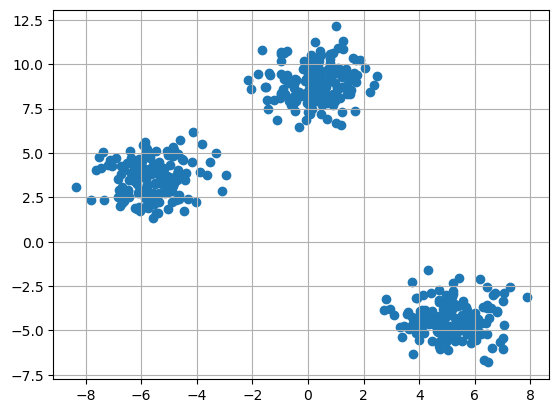

In [52]:
X,y = make_blobs(n_samples = 500,n_features = 2,centers = 3,random_state = 23)

fig = plt.figure(0)
plt.grid(True)
plt.scatter(X[:,0],X[:,1])
plt.show()

In [53]:
k = 3

clusters = {}
np.random.seed(23)

for idx in range(k):
    center = 2*(2*np.random.random((X.shape[1],))-1)
    points = []
    cluster = {
        'center' : center,
        'points' : []
    }
    
    clusters[idx] = cluster
    
clusters

{0: {'center': array([0.06919154, 1.78785042]), 'points': []},
 1: {'center': array([ 1.06183904, -0.87041662]), 'points': []},
 2: {'center': array([-1.11581855,  0.74488834]), 'points': []}}

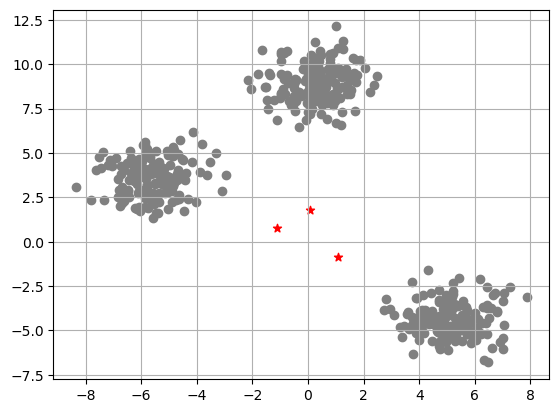

In [54]:
plt.scatter(X[:,0],X[:,1], c = 'gray')
plt.grid(True)
for i in clusters:
    center = clusters[i]['center']
    plt.scatter(center[0],center[1],marker = '*',c = 'red')
plt.show()

In [55]:
def distance(p1,p2):
    return np.sqrt(np.sum((p1-p2)**2))

In [68]:
def assign_clusters(X, clusters):
    for idx in range(X.shape[0]):
        dist = []
        
        curr_x = X[idx]
        
        for i in range(k):
            dis = distance(curr_x,clusters[i]['center'])
            dist.append(dis)
        curr_cluster = np.argmin(dist)
        clusters[curr_cluster]['points'].append(curr_x)
    return clusters

def update_clusters(X, clusters):
    for i in range(k):
        points = np.array(clusters[i]['points'])
        if points.shape[0] > 0:
            new_center = points.mean(axis =0)
            clusters[i]['center'] = new_center
            
            clusters[i]['points'] = []
    return clusters

In [65]:
def pred_cluster(X, clusters):
    pred = []
    for i in range(X.shape[0]):
        dist = []
        for j in range(k):
            dist.append(distance(X[i],clusters[j]['center']))
        pred.append(np.argmin(dist))
    return pred

In [70]:
clusters = assign_clusters(X,clusters)
clusters = update_clusters(X,clusters)
pred = pred_cluster(X,clusters)

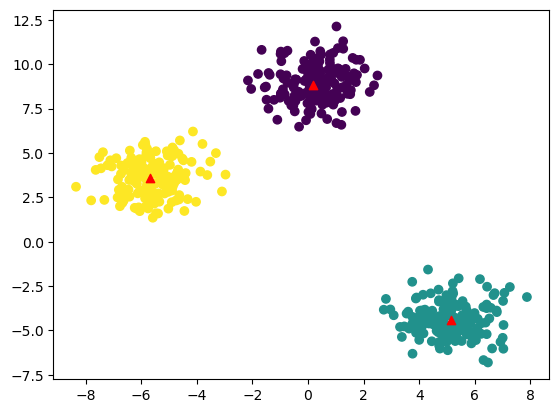

In [71]:
plt.scatter(X[:,0],X[:,1],c = pred)
for i in clusters:
    center = clusters[i]['center']
    plt.scatter(center[0],center[1],marker = '^',c = 'red')
plt.show()